# Faites de votre mieux! (20%) 

In [1]:
from comet_ml import Experiment

In [2]:
from dotenv import load_dotenv
load_dotenv(r".env")
import os

In [3]:
comet_api_key = os.environ.get('COMET_API_KEY')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibrationDisplay, calibration_curve
import pickle
from plots import *
from sklearn.ensemble import RandomForestClassifier

### 1. Classificateur XGBoost en utilisant uniquement les caractéristiques de distance et d'angle 

#### Loading data

In [5]:
data_path = os.environ.get('DATA_DIR')

In [6]:
print(load_dotenv(r".env"))

True


In [31]:
#train_data_path = "./data/nhl_train_data.csv"
#test_data_path = "./data/nhl_test_data.csv"

train_data_path_2 = "./nhl_2016to2019_adv.csv"
test_data_path_2 = "./nhl_2020_adv_1.csv"

In [32]:
#train_data=pd.read_csv(train_data_path)
#test_data=pd.read_csv(test_data_path)

train_data_2=pd.read_csv(train_data_path_2)
test_data_2=pd.read_csv(test_data_path_2)

In [33]:
train_data_2.columns

Index(['period', 'periodTimeInSeconds', 'isGoal', 'typeDeTir', 'x', 'y',
       'distanceToNet', 'relativeAngleToNet', 'previousEventTypeId',
       'previousX', 'previousY', 'distanceFromPrevious', 'timeDiff', 'rebond',
       'angleChange', 'vitesse', 'gameTime', 'homePlayer', 'awayPlayer',
       'homePenaltySecondsRemaining', 'awayPenaltySecondsRemaining',
       'attackingTeamPlayer', 'DefendingTeamPlayer'],
      dtype='object')

In [34]:
train_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305760 entries, 0 to 305759
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   period                       305760 non-null  float64
 1   periodTimeInSeconds          305760 non-null  int64  
 2   isGoal                       305760 non-null  int64  
 3   typeDeTir                    305760 non-null  object 
 4   x                            305760 non-null  float64
 5   y                            305760 non-null  float64
 6   distanceToNet                305760 non-null  float64
 7   relativeAngleToNet           305760 non-null  float64
 8   previousEventTypeId          305760 non-null  object 
 9   previousX                    301611 non-null  float64
 10  previousY                    301612 non-null  float64
 11  distanceFromPrevious         301611 non-null  float64
 12  timeDiff                     305760 non-null  int64  
 13 

In [35]:
train_data_2.sample(3)

,period,periodTimeInSeconds,isGoal,typeDeTir,x,y,distanceToNet,relativeAngleToNet,previousEventTypeId,previousX,...,rebond,angleChange,vitesse,gameTime,homePlayer,awayPlayer,homePenaltySecondsRemaining,awayPenaltySecondsRemaining,attackingTeamPlayer,DefendingTeamPlayer
142567,2.0,375,0,Wrist Shot,-85.0,34.0,34.365681,81.634114,HIT,37.0,...,False,0.000000,20.237143,1575.0,5,5,0,0,5,5
158722,3.0,680,0,Wrist Shot,-73.0,2.0,17.117243,6.709837,SHOT,-72.0,...,True,16.172159,5.100000,3080.0,4,4,225,225,4,4
255618,3.0,244,0,Tip-In,-73.0,4.0,17.464249,13.240520,SHOT,-77.0,...,True,17.639225,0.400000,2644.0,5,5,0,0,5,5


In [36]:
print(train_data_2.shape)
print(test_data_2.shape)

(305760, 23)
(52404, 23)


#### Création de la foret aléatoire et son évaluation

In [37]:
experience_comet = False

In [38]:
train_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305760 entries, 0 to 305759
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   period                       305760 non-null  float64
 1   periodTimeInSeconds          305760 non-null  int64  
 2   isGoal                       305760 non-null  int64  
 3   typeDeTir                    305760 non-null  object 
 4   x                            305760 non-null  float64
 5   y                            305760 non-null  float64
 6   distanceToNet                305760 non-null  float64
 7   relativeAngleToNet           305760 non-null  float64
 8   previousEventTypeId          305760 non-null  object 
 9   previousX                    301611 non-null  float64
 10  previousY                    301612 non-null  float64
 11  distanceFromPrevious         301611 non-null  float64
 12  timeDiff                     305760 non-null  int64  
 13 

In [39]:
# Vérifier s'il y a des NaN dans tout le DataFrame
nan_nb = train_data_2.isna().any().sum()

# Afficher le résultat
print(f"Y a-t-il des NaN dans le DataFrame ? {nan_nb}")

# Vérifier s'il y a des NaN dans chaque colonne
nan_columns = train_data_2.columns[train_data_2.isna().any()]

# Afficher les colonnes avec des NaN
if not nan_columns.empty:
    print(f"Colonnes avec des NaN : {nan_columns}")
else:
    print("Aucune colonne avec NaN.")

Y a-t-il des NaN dans le DataFrame ? 5
Colonnes avec des NaN : Index(['previousX', 'previousY', 'distanceFromPrevious', 'angleChange',
       'vitesse'],
      dtype='object')


In [40]:
train_data_2.dropna(inplace=True)

In [41]:
# Calculer la proportion de valeurs infinies dans le dataframe
inf_proportion = train_data_2.replace([np.inf, -np.inf], np.nan).isna().mean().mean()

# Afficher le nombre total de lignes dans le dataframe
num_rows = len(train_data_2)

print(f"Proportion de valeurs infinies : {inf_proportion:.2%}")
print(f"Nombre total de lignes dans le dataframe : {num_rows}")

Proportion de valeurs infinies : 0.08%
Nombre total de lignes dans le dataframe : 301594


In [42]:
train_data_2 = train_data_2.replace([np.inf, -np.inf], np.nan).dropna()

In [43]:
dummy_object = pd.get_dummies(train_data_2[['typeDeTir', 'previousEventTypeId']])
data = train_data_2.merge(dummy_object, left_index=True, right_index=True)
train_data_2_correct = data.drop(labels = ['typeDeTir', 'previousEventTypeId', 'homePlayer', 'awayPlayer'], axis = 1)

In [44]:
train_data_2_correct.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295973 entries, 0 to 305759
Data columns (total 37 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   period                            295973 non-null  float64
 1   periodTimeInSeconds               295973 non-null  int64  
 2   isGoal                            295973 non-null  int64  
 3   x                                 295973 non-null  float64
 4   y                                 295973 non-null  float64
 5   distanceToNet                     295973 non-null  float64
 6   relativeAngleToNet                295973 non-null  float64
 7   previousX                         295973 non-null  float64
 8   previousY                         295973 non-null  float64
 9   distanceFromPrevious              295973 non-null  float64
 10  timeDiff                          295973 non-null  int64  
 11  rebond                            295973 non-null  bool  

In [46]:
train_data_2_correct.sample(3)

,period,periodTimeInSeconds,isGoal,x,y,distanceToNet,relativeAngleToNet,previousX,previousY,distanceFromPrevious,...,typeDeTir_Wrist Shot,previousEventTypeId_BLOCKED_SHOT,previousEventTypeId_FACEOFF,previousEventTypeId_GIVEAWAY,previousEventTypeId_GOAL,previousEventTypeId_HIT,previousEventTypeId_MISSED_SHOT,previousEventTypeId_PENALTY,previousEventTypeId_SHOT,previousEventTypeId_TAKEAWAY
78238,1.0,172,0,-80.0,-22.0,24.166092,-65.556045,56.0,30.0,145.60,...,False,False,False,False,False,False,False,False,True,False
84024,2.0,681,0,-59.0,19.0,36.359318,31.504267,-44.0,-38.0,58.94,...,True,False,False,False,False,False,False,False,False,True
6443,1.0,118,0,66.0,31.0,39.204592,11.239284,-69.0,22.0,135.30,...,False,False,True,False,False,False,False,False,False,False


In [65]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

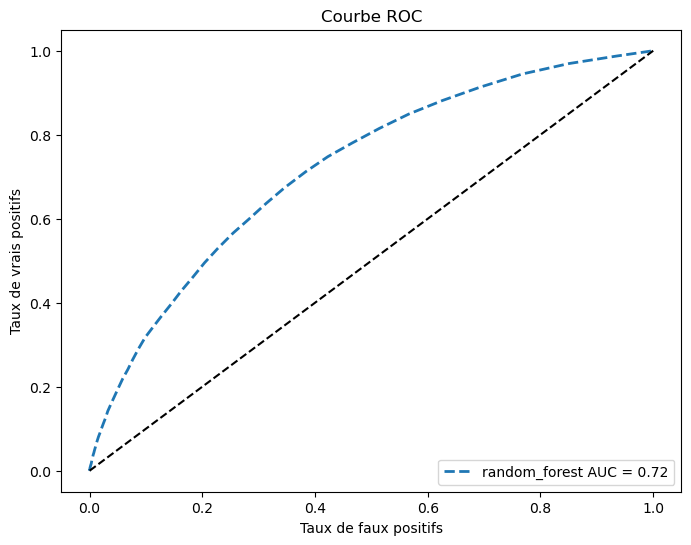

In [71]:

plot_roc_auc([rf], [X_valid], [y_valid], ["random_forest"])

In [130]:
experience_comet = True

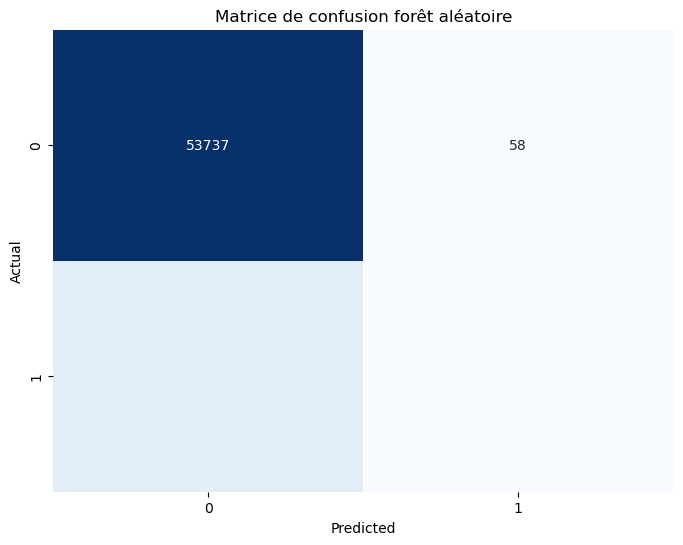

Accuracy: 0.9091139454345806
Accuracy pour la classe 0 : 0.9989218328840971
Accuracy pour la classe 1 : 0.014444444444444444


In [50]:
# Initialisation de l'expérience Comet ML
if experience_comet:
    exp_rf = Experiment(
        api_key=os.environ.get("COMET_API_KEY"), 
        project_name='milestone2', 
        workspace='ift6758-a02'
    )
    exp_rf.set_name("Modèle Forêt aléatoire original")

# on garde que les caractéristique qu'on veut étudier ici
X_train_select = train_data_2_correct.drop('isGoal', axis=1)
y_train_select = train_data_2_correct['isGoal']

# split l'ensemble de données en ensembles d'entraînement et de validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_select, y_train_select, test_size=0.2, random_state=42)


# Initialisation de la forêt aléatoire
rf = RandomForestClassifier(
    random_state=42
)

# Entraîenement
rf.fit(X_train, y_train)

# prédictions sur l'ensemble de validation
y_pred_rf = rf.predict(X_valid)


# Calcul de l'accuracy et de la matrice de confusion
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_valid, y_pred_rf)

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion forêt aléatoire')
plt.show()

# Calcul des accuracies par classe
accuracy_class_0_rf = (y_pred_rf[y_valid.values == 0] == 0).sum() / (y_valid.values == 0).sum()
accuracy_class_1_rf = (y_pred_rf[y_valid.values == 1] == 1).sum() / (y_valid.values == 1).sum()

print(f"Accuracy: {accuracy_rf}")
print(f"Accuracy pour la classe 0 : {accuracy_class_0_rf}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1_rf}")

hyperparams_rf = {
        "bootstrap": rf.bootstrap,
        "criterion": rf.criterion,
        "max_depth": rf.max_depth,
        "max_features": rf.max_features,
        "min_samples_leaf": rf.min_samples_leaf,
        "min_samples_split": rf.min_samples_split,
        "n_estimators": rf.n_estimators,
        "random_state": rf.random_state
    }

model = rf
if experience_comet:
    # Créer le répertoire 'models' s'il n'existe pas
    if not os.path.exists('models'):
        os.makedirs('models')

    pickle.dump(model, open("models/random_forest_origin.pkl", "wb"))

    # Enregistrement des métriques
    exp_rf.log_model("Modèle Forêt aléatoire original", "models/random_forest_origin.pkl")
    exp_rf.log_metric("accuracy", accuracy_rf)
    exp_rf.log_metric("accuracy_class_0", accuracy_class_0_rf)
    exp_rf.log_metric("accuracy_class_1", accuracy_class_1_rf)
    exp_rf.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred_rf, title="Matrice de confusion : forêt aléatoire")
    exp_rf.log_parameters(hyperparams_rf)
    exp_rf.add_tag("random_forest")
    
    
    # Fermeture de l'expérience Comet ML
    exp_rf.end()

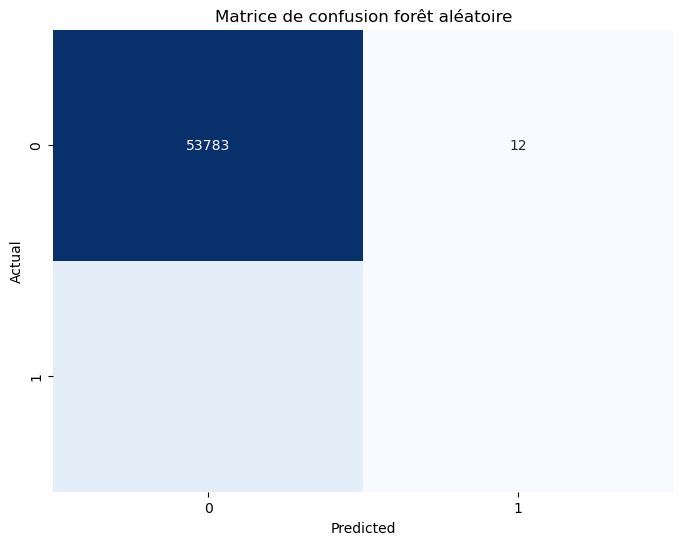

Accuracy: 0.9093166652588901
Accuracy pour la classe 0 : 0.9997769309415373
Accuracy pour la classe 1 : 0.008148148148148147


In [49]:
# Initialisation de l'expérience Comet ML
if experience_comet:
    exp_rf = Experiment(
        api_key=os.environ.get("COMET_API_KEY"), 
        project_name='milestone2', 
        workspace='ift6758-a02'
    )
    exp_rf.set_name("Modèle Forêt aléatoire")

# on garde que les caractéristique qu'on veut étudier ici
X_train_select = train_data_2_correct.drop('isGoal', axis=1)
y_train_select = train_data_2_correct['isGoal']

# split l'ensemble de données en ensembles d'entraînement et de validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_select, y_train_select, test_size=0.2, random_state=42)


# Initialisation de la forêt aléatoire
rf = RandomForestClassifier(
    bootstrap= False, 
    criterion= 'entropy', 
    max_depth= 15, 
    max_features= 'sqrt', 
    min_samples_leaf= 2, 
    min_samples_split= 5, 
    n_estimators=153,
    random_state=42
)

# Entraîenement
rf.fit(X_train, y_train)

# prédictions sur l'ensemble de validation
y_pred_rf = rf.predict(X_valid)


# Calcul de l'accuracy et de la matrice de confusion
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_valid, y_pred_rf)

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion forêt aléatoire')
plt.show()

# Calcul des accuracies par classe
accuracy_class_0_rf = (y_pred_rf[y_valid.values == 0] == 0).sum() / (y_valid.values == 0).sum()
accuracy_class_1_rf = (y_pred_rf[y_valid.values == 1] == 1).sum() / (y_valid.values == 1).sum()

print(f"Accuracy: {accuracy_rf}")
print(f"Accuracy pour la classe 0 : {accuracy_class_0_rf}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1_rf}")

hyperparams_rf = {
        "bootstrap": rf.bootstrap,
        "criterion": rf.criterion,
        "max_depth": rf.max_depth,
        "max_features": rf.max_features,
        "min_samples_leaf": rf.min_samples_leaf,
        "min_samples_split": rf.min_samples_split,
        "n_estimators": rf.n_estimators,
        "random_state": rf.random_state
    }

model = rf
if experience_comet:
    # Créer le répertoire 'models' s'il n'existe pas
    if not os.path.exists('models'):
        os.makedirs('models')

    pickle.dump(model, open("models/random_forest.pkl", "wb"))

    # Enregistrement des métriques
    exp_rf.log_model("Modèle Forêt aléatoire", "models/random_forest.pkl")
    exp_rf.log_metric("accuracy", accuracy_rf)
    exp_rf.log_metric("accuracy_class_0", accuracy_class_0_rf)
    exp_rf.log_metric("accuracy_class_1", accuracy_class_1_rf)
    exp_rf.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred_rf, title="Matrice de confusion : forêt aléatoire")
    exp_rf.log_parameters(hyperparams_rf)
    exp_rf.add_tag("random_forest")
    
    
    # Fermeture de l'expérience Comet ML
    exp_rf.end()

In [ ]:
experience_comet = True 

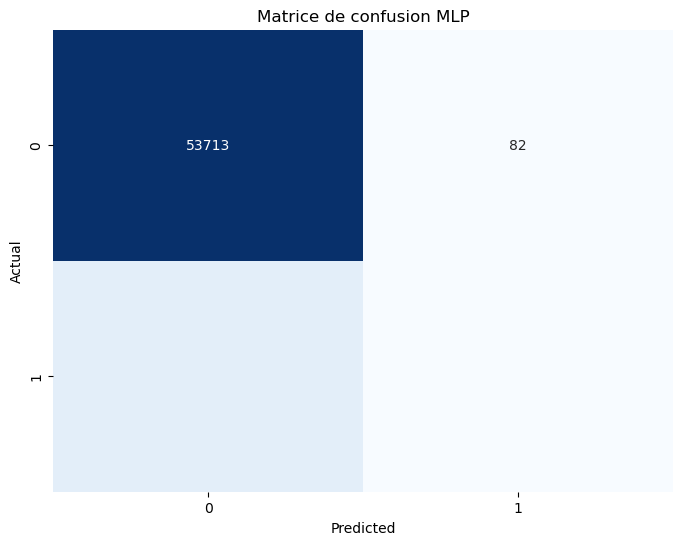

Accuracy (MLP): 0.9086240391924993
Accuracy pour la classe 0 : 0.9984756947671717
Accuracy pour la classe 1 : 0.013518518518518518


In [51]:
from sklearn.neural_network import MLPClassifier

if experience_comet:
    exp_mlp = Experiment(
        api_key=os.environ.get("COMET_API_KEY"), 
        project_name='milestone2', 
        workspace='ift6758-a02'
    )
    exp_mlp.set_name("Modèle MLPClassifier")

# Entraînement du modèle MLP
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), 
                    activation='relu', 
                    solver='adam', 
                    max_iter=300, 
                    random_state=42)
mlp.fit(X_train, y_train)

# Prédictions et évaluation du modèle
y_pred_mlp = mlp.predict(X_valid)
accuracy_mlp = accuracy_score(y_valid, y_pred_mlp)
conf_matrix_mlp = confusion_matrix(y_valid, y_pred_mlp)
# Calcul des accuracies par classe
accuracy_class_0_mlp = (y_pred_mlp[y_valid.values == 0] == 0).sum() / (y_valid.values == 0).sum()
accuracy_class_1_mlp = (y_pred_mlp[y_valid.values == 1] == 1).sum() / (y_valid.values == 1).sum()


# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion MLP')
plt.show()

print(f"Accuracy (MLP): {accuracy_mlp}")
print(f"Accuracy pour la classe 0 : {accuracy_class_0_mlp}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1_mlp}")
print(conf_matrix_mlp)

models=mlp
if experience_comet:
    # Enregistrement des hyperparamètres
    hyperparams_mlp = {
        "hidden_layer_sizes": mlp.hidden_layer_sizes,
        "activation": mlp.activation,
        "solver": mlp.solver,
        "max_iter": mlp.max_iter,
        "random_state": mlp.random_state
    }
    exp_mlp.log_parameters(hyperparams_mlp)
    exp_mlp.log_metric("accuracy", accuracy_mlp)
    exp_mlp.log_metric("accuracy_class_0", accuracy_class_0_mlp)
    exp_mlp.log_metric("accuracy_class_1", accuracy_class_1_mlp)
    exp_mlp.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred_mlp, title="Matrice de confusion MLP")

    # Sauvegarde du modèle
    if not os.path.exists('models'):
        os.makedirs('models')
    with open("models/mlp_model.pkl", "wb") as f:
        pickle.dump(mlp, f)
    exp_mlp.log_model("Modèle MLPClassifier", "models/mlp_model.pkl")
    exp_mlp.add_tag("Neural_network")
    # Fermeture de l'expérience Comet ML
    exp_mlp.end()

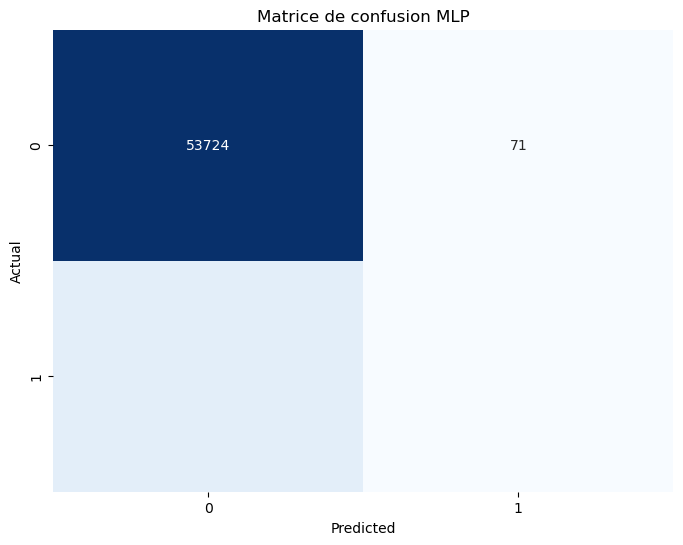

Accuracy (MLP): 0.90835374609342
Accuracy pour la classe 0 : 0.9986801747374291
Accuracy pour la classe 1 : 0.008518518518518519


In [52]:
from sklearn.neural_network import MLPClassifier

if experience_comet:
    exp_mlp = Experiment(
        api_key=os.environ.get("COMET_API_KEY"), 
        project_name='milestone2', 
        workspace='ift6758-a02'
    )
    exp_mlp.set_name("Modèle MLPClassifier - Meilleurs hyperparametre selon grille")

#Meilleurs hyperparamètres trouvés: {'solver': 'adam', 'max_iter': 200, 'hidden_layer_sizes': (64, 32), 'activation': 'relu'}
# Entraînement du modèle MLP
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', 
                    max_iter=200, random_state=42)
mlp.fit(X_train, y_train)

# Prédictions et évaluation du modèle
y_pred_mlp = mlp.predict(X_valid)
accuracy_mlp = accuracy_score(y_valid, y_pred_mlp)
conf_matrix_mlp = confusion_matrix(y_valid, y_pred_mlp)
# Calcul des accuracies par classe
accuracy_class_0_mlp = (y_pred_mlp[y_valid.values == 0] == 0).sum() / (y_valid.values == 0).sum()
accuracy_class_1_mlp = (y_pred_mlp[y_valid.values == 1] == 1).sum() / (y_valid.values == 1).sum()


# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion MLP')
plt.show()

print(f"Accuracy (MLP): {accuracy_mlp}")
print(f"Accuracy pour la classe 0 : {accuracy_class_0_mlp}")
print(f"Accuracy pour la classe 1 : {accuracy_class_1_mlp}")

models=mlp
if experience_comet:
    # Enregistrement des hyperparamètres
    hyperparams_mlp = {
        "hidden_layer_sizes": mlp.hidden_layer_sizes,
        "activation": mlp.activation,
        "solver": mlp.solver,
        "max_iter": mlp.max_iter,
        "random_state": mlp.random_state
    }
    exp_mlp.log_parameters(hyperparams_mlp)
    exp_mlp.log_metric("accuracy", accuracy_mlp)
    exp_mlp.log_metric("accuracy_class_0", accuracy_class_0_mlp)
    exp_mlp.log_metric("accuracy_class_1", accuracy_class_1_mlp)
    exp_mlp.log_confusion_matrix(y_true=y_valid, y_predicted=y_pred_mlp, title="Matrice de confusion MLP")

    # Sauvegarde du modèle
    if not os.path.exists('models'):
        os.makedirs('models')
    with open("models/mlp_model_best_param.pkl", "wb") as f:
        pickle.dump(mlp, f)
    exp_mlp.log_model("Modèle MLPClassifier_best_param", "models/mlp_model_best_param.pkl")
    exp_mlp.add_tag("Neural_network")
    # Fermeture de l'expérience Comet ML
    exp_mlp.end()


In [166]:
from sklearn.model_selection import RandomizedSearchCV
# Définition de la grille d'hyperparamètres (sous forme de distributions si nécessaire)
param_distributions = {
    'hidden_layer_sizes': [(50,), (100,), (128, 64), (128, 128), (64, 32)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'max_iter': [100, 200, 300]
}

# Initialisation du MLPClassifier
mlp = MLPClassifier(random_state=42)

# Création d'un scorer personnalisé basé sur l'accuracy
accuracy_scorer = make_scorer(accuracy_score)

# Initialisation de la recherche aléatoire avec validation croisée
random_search = RandomizedSearchCV(
    mlp, 
    param_distributions, 
    n_iter=10,
    scoring='accuracy', 
    cv=3, 
    random_state=42
)

# Entraînement de RandomizedSearchCV
random_search.fit(X_train, y_train)

# Affichage des meilleurs hyperparamètres
best_params = random_search.best_params_
print("Meilleurs hyperparamètres trouvés:", best_params)



/Users/canelle/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/canelle/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/canelle/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/canelle/anaconda3/envs/ift6758

Meilleurs hyperparamètres trouvés: {'solver': 'adam', 'max_iter': 200, 'hidden_layer_sizes': (64, 32), 'activation': 'relu'}


In [167]:
#Meilleurs hyperparamètres trouvés: {'solver': 'adam', 'max_iter': 200, 'hidden_layer_sizes': (64, 32), 'activation': 'relu'}

In [ ]:
#from sklearn.metrics import classification_report
#print(classification_report(y_valid, y_pred))

In [118]:
conf_matrix_mlp

array([[53792,     3],
       [ 5391,     9]])

In [81]:
import skopt


In [119]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Définir l'espace des hyperparamètres
param_dist = {
    'criterion': ["gini", "entropy"],
    'bootstrap': [True, False],
    'max_depth': sp_randint(10, 100),
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': sp_randint(1, 4),
    'min_samples_split': sp_randint(2, 10),
    'n_estimators': sp_randint(100, 200)
}

# Initialiser le modèle
model = RandomForestClassifier(random_state=42)

# Initialiser RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, 
                                   n_iter=32, scoring='roc_auc', cv=5, 
                                   random_state=42)

# Entraîner RandomizedSearchCV
random_search.fit(X_train, y_train)

# Afficher les résultats
print("Meilleurs hyperparamètres : ", random_search.best_params_)
print("Meilleure performance (AUC) : ", random_search.best_score_)


Meilleurs hyperparamètres :  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 153}
Meilleure performance (AUC) :  0.7485080336590181


In [120]:
# Meilleurs hyperparamètres :  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 153}
# Meilleure performance (AUC) :  0.7485080336590181